# Auto-Encoders

- [Auto-Encoder in Wikipedia, Must Read](https://en.wikipedia.org/wiki/Autoencoder)
- [A good blog by Lilian Weng](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)


<a title="Chervinskii / CC BY-SA (https://creativecommons.org/licenses/by-sa/4.0)" href="https://commons.wikimedia.org/wiki/File:Autoencoder_structure.png"><img width="512" alt="Autoencoder structure" src="https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png"></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### ColorMap Allocation for display

In [2]:
cc = plt.get_cmap('tab10')
colors = cc(np.arange(10))

## Dataset

In [3]:
batch_size = 100
in_features = 28*28

data_loader = {tv: torch.utils.data.DataLoader(
                        torchvision.datasets.MNIST('../data', train=tv=='train', 
                                                   transform=torchvision.transforms.Compose([
                                                                                     torchvision.transforms.ToTensor(),
                                                                                     torchvision.transforms.Lambda(lambda im: im.reshape(-1))]), 
                                                   download=True),
                        shuffle=tv=='train',
                        batch_size=batch_size)
               for tv in ['train', 'val']
              }

In [4]:
dstr = data_loader['train'].dataset
len(dstr), dstr[0][0].shape

dstr_np = np.empty((len(dstr), dstr[0][0].shape[0]))
dstr_labels = np.empty(len(dstr), dtype=int)

for i in range(dstr_np.shape[0]):
    dstr_np[i] = dstr[i][0].numpy()
    dstr_labels[i] = int(dstr[i][1])

In [5]:
dstr_labels[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

## Projection to 2D space by tSNE

In [6]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

some = np.random.permutation(len(dstr_labels))
some[:10]

array([20885, 22386,  2752, 27541, 40650,  9989, 28212, 17021, 46566,
       18062])

In [7]:
%%time
N=1000
z_embedded = TSNE(n_components=2).fit_transform(dstr_np[some[:N]])

Wall time: 4.5 s


In [8]:
z_embedded.shape

(1000, 2)

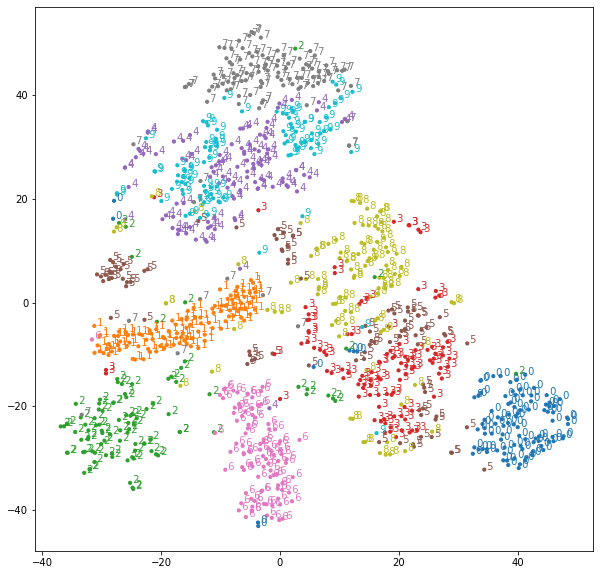

In [9]:
plt.figure(figsize=(10,10))
plt.scatter(z_embedded[:,0], z_embedded[:,1], c=colors[dstr_labels[some[:N]]], s=10, alpha=1)

for k, i in enumerate(dstr_labels[some[:N]]):
      plt.text(z_embedded[k,0], z_embedded[k,1], f' {i}', color=colors[i])

### Projectioni to 2D space by PCA

In [10]:
import numpy as np
from sklearn.decomposition import PCA

z_embedded = PCA(n_components=2).fit_transform(dstr_np[some[:N]])

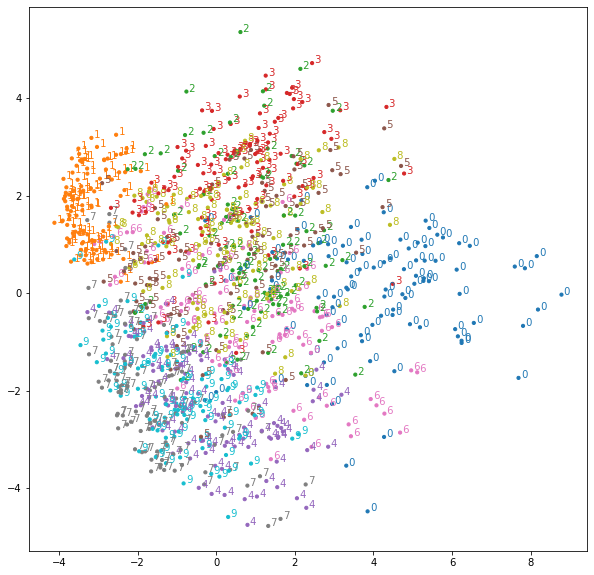

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(z_embedded[:,0], z_embedded[:,1], c=colors[dstr_labels[some[:N]]], s=10, alpha=1)

for k, i in enumerate(dstr_labels[some[:N]]):
      plt.text(z_embedded[k,0], z_embedded[k,1], f' {i}', color=colors[i])

## Linear Autoencoder with nn.Tanh()

- Only one hidden layer connected through a feed forward linear layer

In [12]:
activation_functions = {'tanh': nn.Tanh(), 'relu': nn.ReLU(inplace=True), 'elu': nn.ELU(inplace=True)}

class AutoEncoderLinear(nn.Module):
    """ AutoEncoder wiht 1 Linear Layer"""
    def __init__(self, in_features, hidden_size, activation='tanh'):
        super(AutoEncoderLinear, self).__init__()
        
        self.encoder = nn.Sequential(nn.Linear(in_features, hidden_size), 
                                     activation_functions[activation])
        self.decoder = nn.Sequential(nn.Linear(hidden_size, in_features), 
                                     nn.Sigmoid()) # x in [0,1]

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
#

### Training

- Loss function:
    - MSELoss()
    - Binary Cross Entropy Loss() 

In [13]:
hidden_size = 32
model = AutoEncoderLinear(in_features=in_features, 
                          hidden_size=hidden_size, 
                          activation='tanh').to(device)

criterion = nn.MSELoss().to(device)

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Sanity Check

In [14]:
for batch, _ in data_loader['train']:
    batch = batch.to(device)
    pred = model(batch)
    break
print(batch.shape, pred.shape)

torch.Size([100, 784]) torch.Size([100, 784])


In [15]:
# def trainin_loop_regression(n_epochs, model, criterion, optimizer, )

n_epochs = 50

for epoch in range(1, n_epochs+1):
    train_loss = 0
    n_data = 0
    for batch, label in data_loader['train']: # we do not need label
        batch = batch.to(device)
        pred = model(batch)
        loss = criterion(pred, batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item() * batch.shape[0]
        n_data += batch.shape[0]
    train_loss /= n_data
    print(f'loss[{epoch:3d}/{n_epochs}] {train_loss:.7f}', end='\r')

### Display the encode/decode results

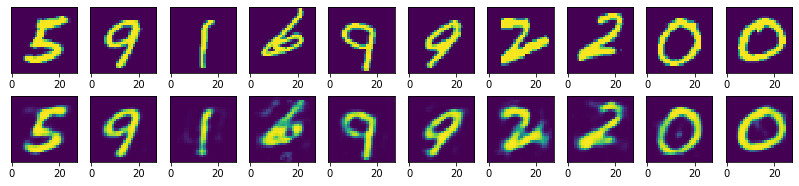

In [16]:
batch, _ = next(iter(data_loader['train']))
decoded = model(batch.to(device).view(batch.shape[0], -1)).detach().cpu().numpy()
decoded.shape
fig, axes = plt.subplots(2,10, figsize=(14,3))
for i in range(10):
    axes[0][i].imshow(batch[i].reshape(28,28))    
    axes[1][i].imshow(decoded[i].reshape(28,28))
    axes[0][i].axes.get_yaxis().set_visible(False)
    axes[1][i].axes.get_yaxis().set_visible(False)

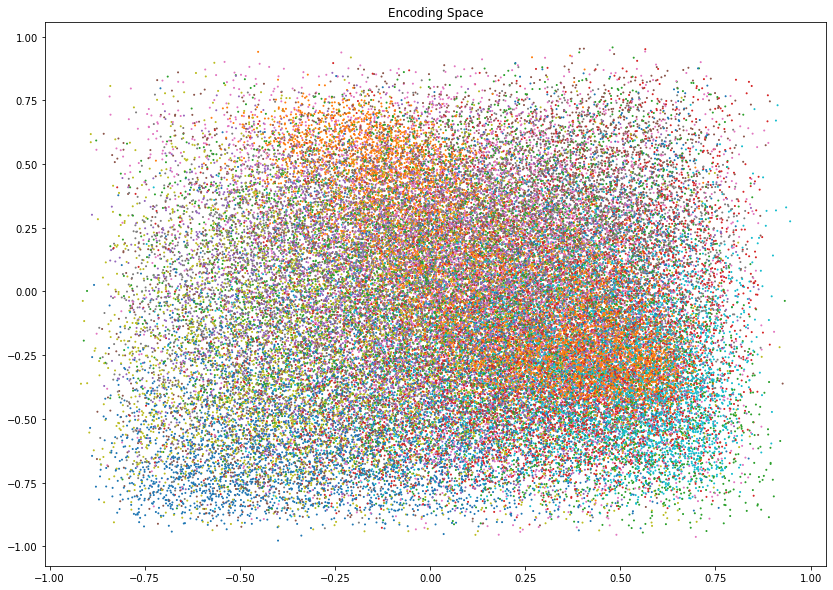

In [17]:
plt.figure(figsize=(14,10))
label_count = np.zeros((10))
printed = np.zeros((10), dtype=np.bool)
with torch.no_grad():
    for batch, label in data_loader['train']:
        batch = batch.to(device).view(batch.shape[0], -1)
        z = model.encoder(batch).detach().cpu().numpy()
        plt.scatter(z[:,1], z[:,2], c=colors[label], s=1, alpha=1)
        
plt.title('Encoding Space');

In [18]:
np.histogram(label, bins=10, range=(0, 10))

(array([ 9, 15,  9,  9, 10,  8,  8, 16,  8,  8], dtype=int64),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))

In [19]:
def get_encoded(model, dataloader, N=200):
    codes = []
    labels = []
    label_count = np.zeros((10))
    with torch.no_grad():
        for batch, label in dataloader:
            batch = batch.to(device)
            
            z = model.encoder(batch).detach().cpu().numpy().reshape(batch_size, -1)

            codes.append(z)
            labels.append(label.numpy())
            
            unik_labels, counts = np.unique(label, return_counts=True)
            label_count[unik_labels] += counts
            if N > 0 and label_count.min() >= N:
                break
    #
    codes = np.array(codes)
    codes = codes.reshape(-1, codes.shape[-1])
    labels = np.array(labels).reshape(-1)
    codes.shape, labels
    return codes, labels

def plot_codes(codes, labels, title=None, N=200):
    plt.figure(figsize=(14,10))
    print(f'plot_codes(): {codes.shape} {labels.shape}')
    z = codes
    plt.scatter(z[:,0], z[:,1], c=colors[labels], s=1, alpha=1)
    for i, lbl in enumerate(labels):
        plt.text(z[i,0], z[i,1], f'{lbl}', color=colors[lbl])

    plt.colorbar();
    title = title if title is not None else f'Encoding Space. Ploted: {N} data'
    plt.title(title);

    
def plot_encoded(model, dataloader, title=None, N=200):
    plt.figure(figsize=(14,10))
    label_count = np.zeros((10))
    printed = np.zeros((10), dtype=np.bool)
    with torch.no_grad():
        for batch, label in dataloader:
            batch = batch.to(device)
            z = model.encoder(batch).detach().cpu().numpy().reshape(batch_size, -1)
            plt.scatter(z[:,0], z[:,1], c=colors[label], s=1, alpha=1)

            for k, i in enumerate(label):
                 plt.text(z[k,0], z[k,1], f'{i}', color=colors[i])

            unik_labels, counts = np.unique(label, return_counts=True)
            label_count[unik_labels] += counts
            if label_count.min() > N:
                break
    plt.colorbar();
    title = title if title is not None else f'Encoding Space. Ploted: {N} data'
    plt.title(title);

In [20]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_embedded(model, dl, method='tsne'):
    # perform encoding 
    codes, labels = get_encoded(model, dl, N=-1)

    if method == 'tsne':
        # tSNE embedding to 2D Euclidean space
        z_embedded = TSNE(n_components=2).fit_transform(codes)
    elif method == 'pca':
        z_embedded = PCA(n_components=2).fit_transform(codes)
        
    plt.figure(figsize=(10,10))
    plt.scatter(z_embedded[:,0], z_embedded[:,1], c=colors[labels], s=10, alpha=1)

    print(labels.shape)
    for k, i in enumerate(labels[:500]):
          plt.text(z_embedded[k,0], z_embedded[k,1], f' {i}', color=colors[i])

(10000,)
Wall time: 49 s


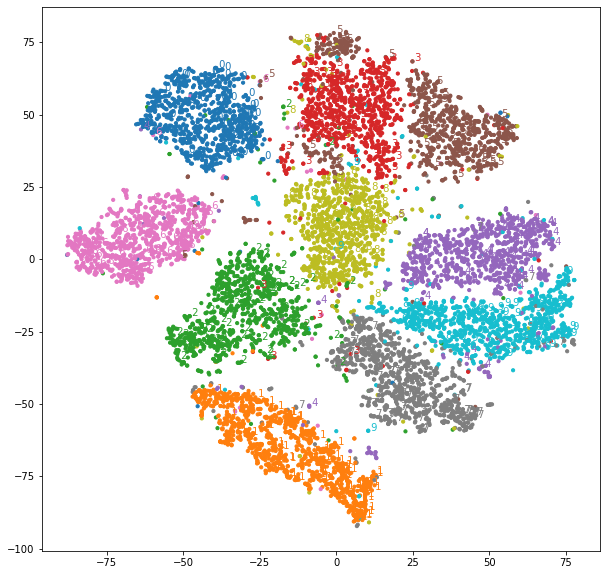

In [21]:
%%time
plot_embedded(model, data_loader['val'])

Linear AE has shown a large difference in the results depending on the change of `batch_size`s. More experiments and thoughts are required.

---
## Linear Autoencoder with nn.ReLU()

- Only one hidden layer connected through a feed forward linear layer

In [22]:
model = AutoEncoderLinear(in_features=in_features, 
                          hidden_size=32, 
                          activation='relu').to(device)

criterion = nn.MSELoss().to(device)

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
n_epochs = 50

for epoch in range(1, n_epochs+1):
    train_loss = 0
    for batch, label in data_loader['train']: # we do not need label
        batch = batch.to(device)
        pred = model(batch)
        loss = criterion(pred, batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item() * batch.shape[0]
    train_loss /= len(data_loader)
    print(f'loss[{epoch:3d}/{n_epochs}] {train_loss:.7f}', end='\r')

### Display the encode/decode results

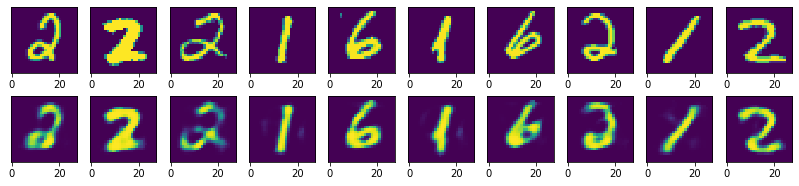

In [24]:
batch, _ = next(iter(data_loader['train']))
decoded = model(batch.to(device)).detach().cpu().numpy()
decoded.shape
fig, axes = plt.subplots(2,10, figsize=(14,3))
for i in range(10):
    axes[0][i].imshow(batch[i].reshape(28,28))    
    axes[1][i].imshow(decoded[i].reshape(28,28))
    axes[0][i].axes.get_yaxis().set_visible(False)
    axes[1][i].axes.get_yaxis().set_visible(False)

---
## Convolutinal Auto Encoder

In [25]:
batch_size = 100

data_loader = {tv: torch.utils.data.DataLoader(
                        torchvision.datasets.MNIST('../data', train=tv=='train', 
                                                   transform=torchvision.transforms.ToTensor(),
                                                   download=True),
                        shuffle=tv=='train',
                        batch_size=batch_size)
               for tv in ['train', 'val']
              }

In [26]:
def cbn(inf, outf, ksize=3, stride=1, padding=1, relu=True):
    net = nn.Sequential(nn.Conv2d(inf, outf, ksize, stride=stride, padding=padding),
                        nn.BatchNorm2d(outf))
    if relu:
        net.add_module('relu', nn.ReLU(True))
        
    return net
#

class AutoEncoderConv(nn.Module):
    def __init__(self, latent_dim=32, encoder_activation=None):
        super(AutoEncoderConv, self).__init__()

        self.encoder = nn.Sequential(
                            cbn(1,4), # 28 28
                            cbn(4,4, stride=2),  # 14,14
                            cbn(4, 8),
                            cbn(8, 8, stride=2),  # 7,7
                            cbn(8, 16),
                            cbn(16,16, stride=2),     # 4 4
                            cbn(16, 32),
                            cbn(32, 32, stride=2),                # 2 2
                            cbn(32, latent_dim, stride=2, relu=False), # w/o ReLU, 1x1
                            # Final Activation may also be included here.
        )
        
        if encoder_activation is 'tanh':
            self.encoder.add_module('encoder activation', nn.Tanh())
            
        self.decoder = nn.Sequential(
                            nn.Upsample(scale_factor=2, align_corners=True, mode='bilinear'),  # 2
                            cbn(latent_dim, 32),
                            nn.Upsample(scale_factor=2, align_corners=True, mode='bilinear'),  # 4
                            cbn(32, 32),
                            nn.Upsample(scale_factor=2, align_corners=True, mode='bilinear'),  # 8
                            cbn(32, 16),
                            nn.Upsample(scale_factor=2, align_corners=True, mode='bilinear'),  # 16
                            cbn(16, 8),
                            nn.Upsample(scale_factor=2, align_corners=True, mode='bilinear'),  # 16
                            cbn(8, 4),
                            nn.Upsample(size=(28,28), mode='bilinear', align_corners=True),
                            cbn(4, 1, relu=False),
                            nn.Sigmoid()   # output range [0, 1], so we may choose MSELoss or BinaryCrossEntropyLoss
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [27]:
# sanity check
model = AutoEncoderConv()
batch, _ = next(iter(data_loader['train']))
print('Encoder Output: ', model.encoder(batch).shape)
pred = model(batch)
batch.shape, pred.shape, 

Encoder Output:  torch.Size([100, 32, 1, 1])


(torch.Size([100, 1, 28, 28]), torch.Size([100, 1, 28, 28]))

In [28]:
model

AutoEncoderConv(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(8, 16, kernel_size=

In [29]:
model_32 = AutoEncoderConv(latent_dim=32).to(device)

criterion = nn.MSELoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.Adam(model_32.parameters(), lr=learning_rate)

Text(0.5, 1.0, 'Evolution of training loss (MSE). Final=2.27443600515835')

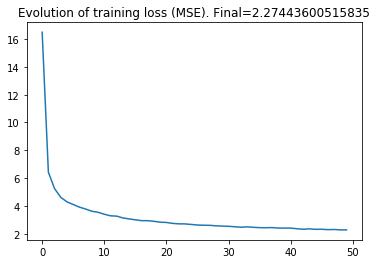

In [30]:
n_epochs = 50
history = []
for epoch in range(1, n_epochs+1):
    train_loss = 0
    for batch, label in data_loader['train']: # we do not need label
        batch = batch.to(device)
        pred = model_32(batch)
        loss = criterion(pred, batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item() * batch.shape[0]
    train_loss /= len(data_loader)*batch_size
    print(f'loss[{epoch:3d}/{n_epochs}] {train_loss:10.7f}', end='\r')
    history.append(train_loss)
#
plt.plot(history)
plt.title(f'Evolution of training loss (MSE). Final={history[-1]}')

### Display the encode/decode results

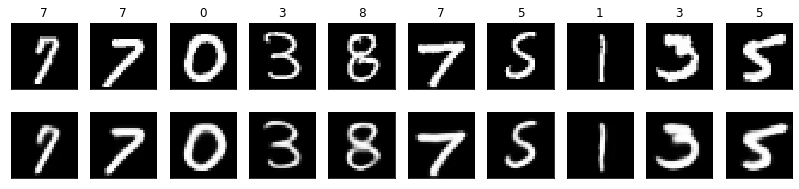

In [31]:
batch, label = next(iter(data_loader['train']))
decoded = model_32(batch.to(device)).detach().cpu().numpy()
decoded.shape
fig, axes = plt.subplots(2,10, figsize=(14,3))
for i in range(10):
    axes[0][i].imshow(batch[i].reshape(28,28), cmap='gray')    
    axes[0][i].set_title(f'{label[i]}')
    axes[1][i].imshow(decoded[i].reshape(28,28), cmap='gray')
    axes[0][i].axes.get_yaxis().set_visible(False); axes[0][i].axes.get_xaxis().set_visible(False)
    axes[1][i].axes.get_yaxis().set_visible(False); axes[1][i].axes.get_xaxis().set_visible(False)

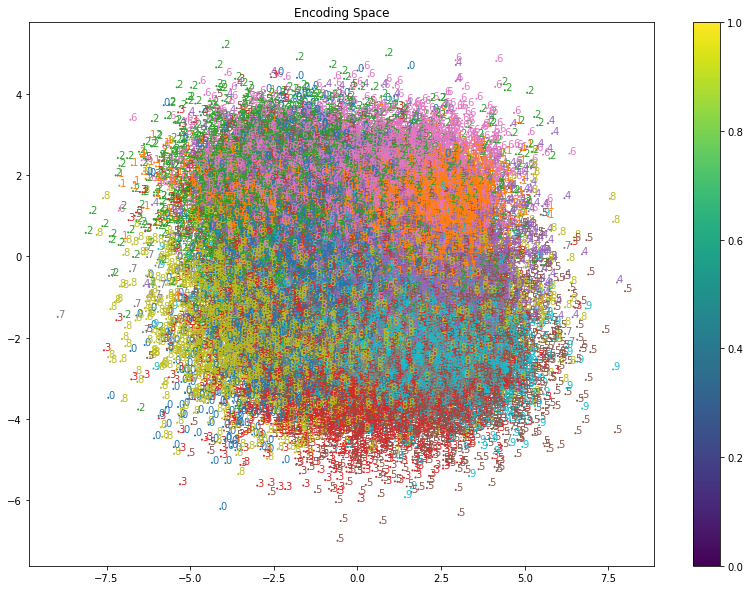

In [35]:
plt.figure(figsize=(14,10))
label_count = np.zeros((10))
printed = np.zeros((10), dtype=np.bool)
with torch.no_grad():
    for batch, label in data_loader['train']:
        batch = batch.to(device)
        z = model_32.encoder(batch).detach().cpu().numpy().reshape(batch_size, -1)
        plt.scatter(z[:,0], z[:,1], c=colors[label], s=1, alpha=1)
        
        for k, i in enumerate(label):
             plt.text(z[k,0], z[k,1], f'{i}', color=colors[i])
    plt.colorbar();
plt.title('Encoding Space');

### tSNE

(2400, 32) (2400,)
plot_codes(): (2400, 32) (2400,)


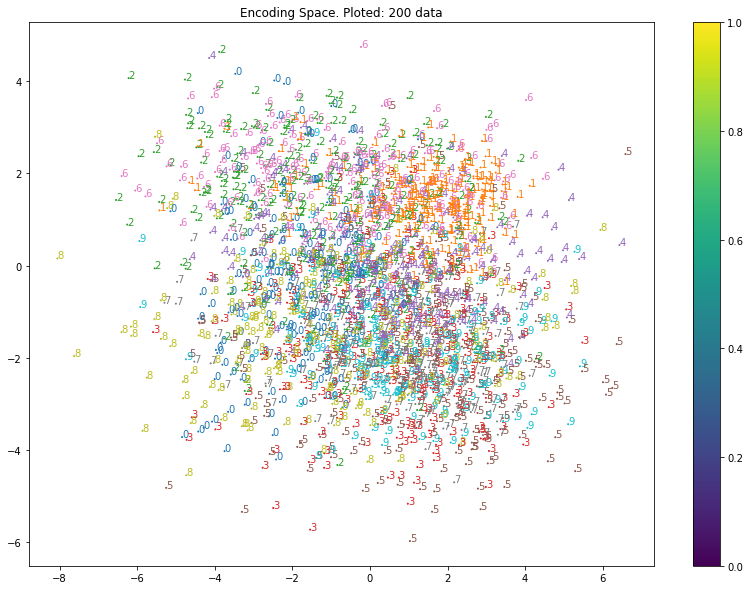

In [36]:
N=200 #len(data_loader['val'])*batch_size
codes, labels = get_encoded(model_32, data_loader['val'], N=N)
print(codes.shape, labels.shape)
plot_codes(codes, labels, N=N)

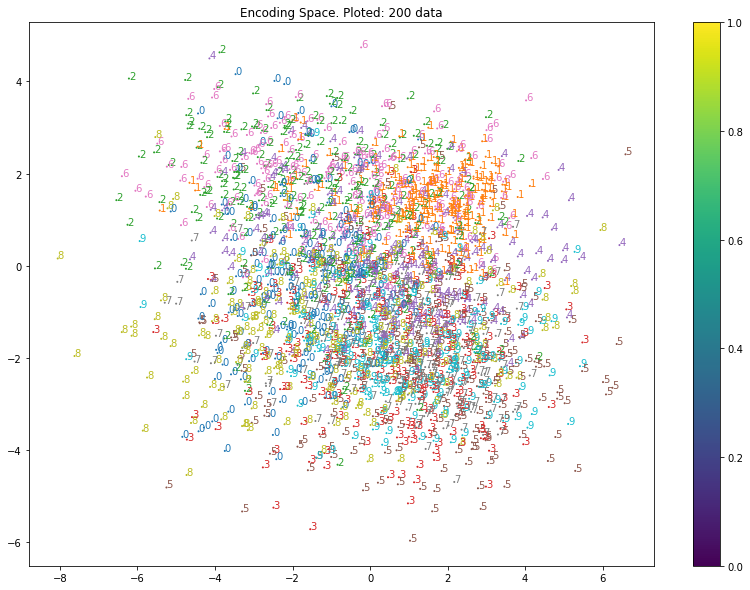

In [37]:
plot_encoded(model_32, data_loader['val'])

In [38]:
%%time
import numpy as np
from sklearn.manifold import TSNE

# perform encoding 
codes, labels = get_encoded(model_32, data_loader['val'], N=-1)

# tSNE embedding to 2D Euclidean space
z_embedded = TSNE(n_components=2).fit_transform(codes)

Wall time: 51.4 s


(10000,)


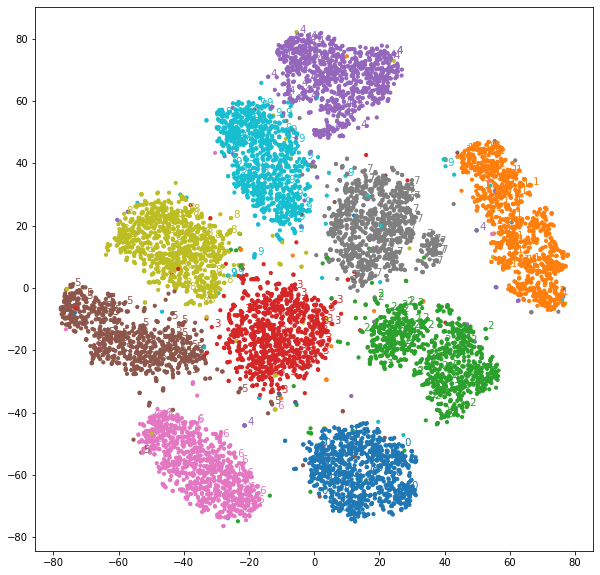

In [39]:
plt.figure(figsize=(10,10))
plt.scatter(z_embedded[:,0], z_embedded[:,1], c=colors[labels], s=10, alpha=1)

print(labels.shape)
for k, i in enumerate(labels[:500]):
      plt.text(z_embedded[k,0], z_embedded[k,1], f' {i}', color=colors[i])

---
## Convolutinal Auto Encoder with Latent Dim = 2

In [40]:
model = AutoEncoderConv(latent_dim=2).to(device)

criterion = nn.MSELoss().to(device)

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Text(0.5, 1.0, 'Evolution of training loss (MSE). Final=1133.454593271017')

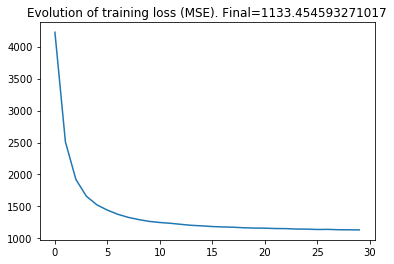

In [41]:
n_epochs = 30
history = []
for epoch in range(1, n_epochs+1):
    train_loss = 0
    for batch, label in data_loader['train']: # we do not need label
        batch = batch.to(device)
        pred = model(batch)
        loss = criterion(pred, batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item() * batch.shape[0]
    train_loss /= len(data_loader)
    print(f'loss[{epoch:3d}/{n_epochs}] {train_loss:.7f}', end='\r')
    history.append(train_loss)
#
plt.plot(history)
plt.title(f'Evolution of training loss (MSE). Final={history[-1]}')

### Display the encode/decode results

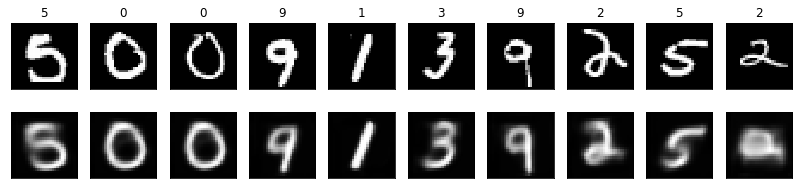

In [42]:
batch, label = next(iter(data_loader['train']))
decoded = model(batch.to(device)).detach().cpu().numpy()
decoded.shape
fig, axes = plt.subplots(2,10, figsize=(14,3))
for i in range(10):
    axes[0][i].imshow(batch[i].reshape(28,28), cmap='gray')    
    axes[0][i].set_title(f'{label[i]}')
    axes[1][i].imshow(decoded[i].reshape(28,28), cmap='gray')
    axes[0][i].axes.get_yaxis().set_visible(False); axes[0][i].axes.get_xaxis().set_visible(False)
    axes[1][i].axes.get_yaxis().set_visible(False); axes[1][i].axes.get_xaxis().set_visible(False)

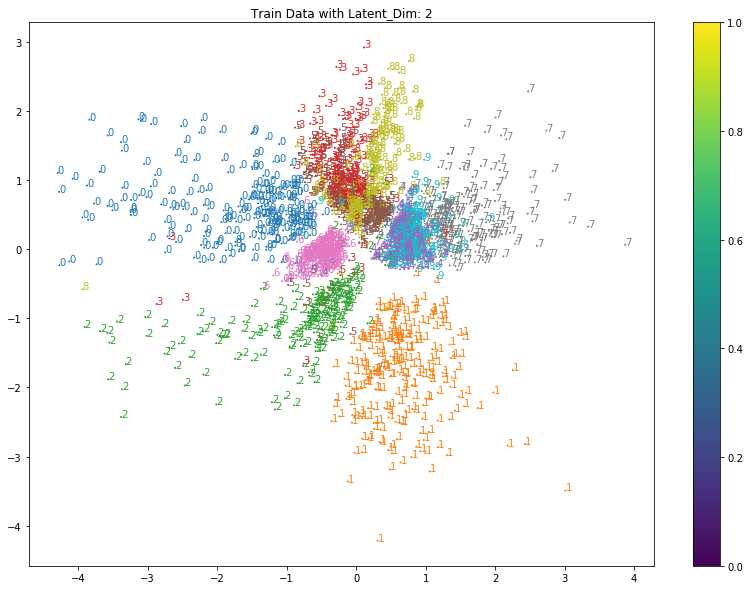

In [43]:
plot_encoded(model, data_loader['train'], 'Train Data with Latent_Dim: 2')

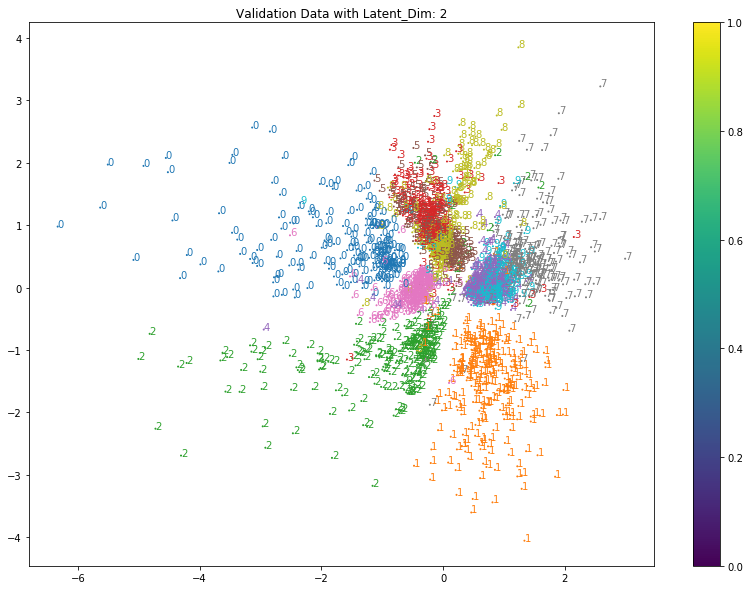

In [44]:
plot_encoded(model, data_loader['val'], 'Validation Data with Latent_Dim: 2')

---
## Convolutinal Auto Encoder with Latent Dim = 2, nn.Tanh() as Encoder Activation

In [45]:
model = AutoEncoderConv(latent_dim=2, 
                        encoder_activation='tanh').to(device)
print(model)

criterion = nn.MSELoss().to(device)

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

AutoEncoderConv(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(8, 16, kernel_size=

Text(0.5, 1.0, 'Evolution of training loss (MSE). Final=1277.73')

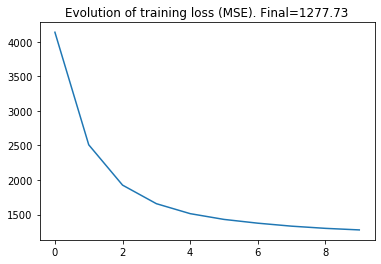

In [46]:
n_epochs = 10
history = []
for epoch in range(1, n_epochs+1):
    train_loss = 0
    for batch, label in data_loader['train']: # we do not need label
        batch = batch.to(device)
        pred = model(batch)
        loss = criterion(pred, batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item() * batch.shape[0]
    train_loss /= len(data_loader)
    print(f'loss[{epoch:3d}/{n_epochs}] {train_loss:10.7f}', end='\r')
    history.append(train_loss)
#
plt.plot(history)
plt.title(f'Evolution of training loss (MSE). Final={history[-1]:.2f}')

### Display the encode/decode results

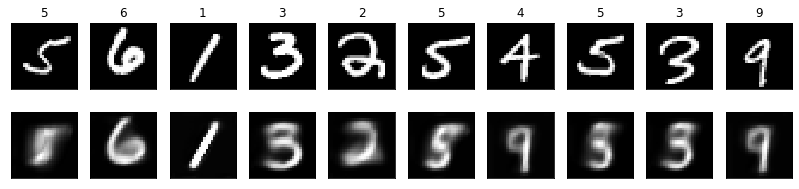

In [47]:
batch, label = next(iter(data_loader['train']))
decoded = model(batch.to(device)).detach().cpu().numpy()
decoded.shape
fig, axes = plt.subplots(2,10, figsize=(14,3))
for i in range(10):
    axes[0][i].imshow(batch[i].reshape(28,28), cmap='gray')    
    axes[0][i].set_title(f'{label[i]}')
    axes[1][i].imshow(decoded[i].reshape(28,28), cmap='gray')
    axes[0][i].axes.get_yaxis().set_visible(False); axes[0][i].axes.get_xaxis().set_visible(False)
    axes[1][i].axes.get_yaxis().set_visible(False); axes[1][i].axes.get_xaxis().set_visible(False)

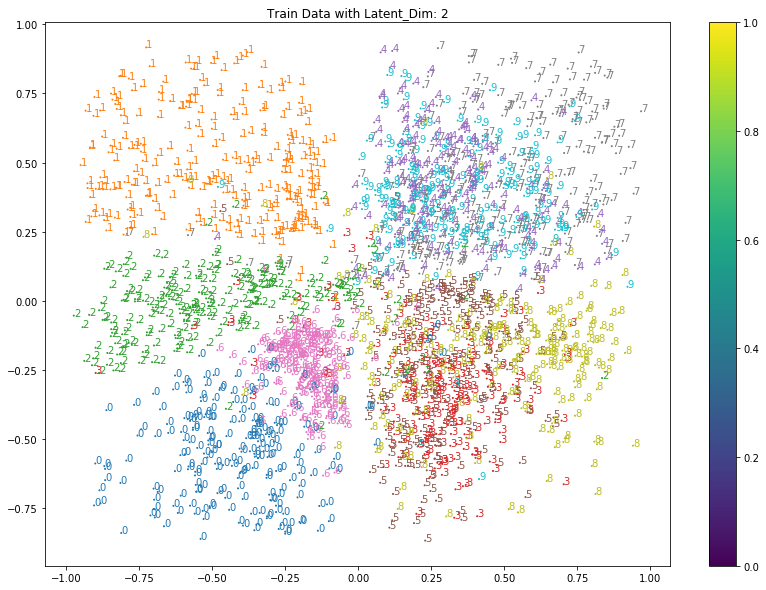

In [48]:
plot_encoded(model, data_loader['train'], 'Train Data with Latent_Dim: 2')

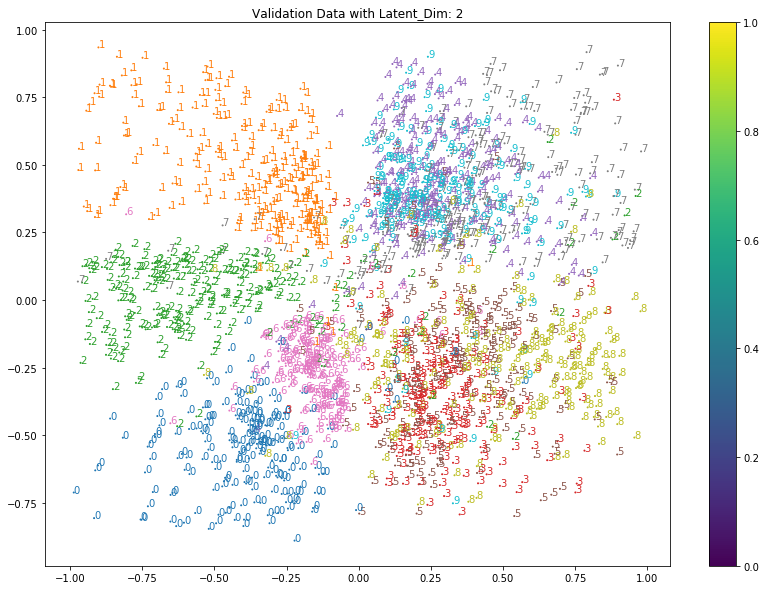

In [49]:
plot_encoded(model, data_loader['val'], 'Validation Data with Latent_Dim: 2')

In [50]:
code = torch.tensor([0.4, 0.13210]).reshape(1,2,1,1).to(device)
code

tensor([[[[0.4000]],

         [[0.1321]]]], device='cuda:0')

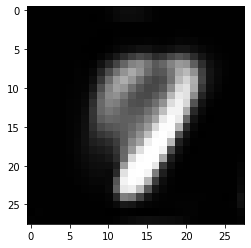

In [51]:
with torch.no_grad():
    decoded = model.decoder(code).detach().cpu().numpy().reshape(28,28)
decoded.shape
plt.imshow(decoded, cmap='gray')

###### ---

## Summary

- Autoencoder is a compressor/encoder using a neural network. Decoder is trained at the same time.
- It seems not bad
- Encoding into 2D space shows a sort of clustering, but not exactly. 
    - There could be a way to do autoencoding and unsupervisded clustering at the same time.
- It is not clear how to choose the dimension of the latent space. It may depend on its real application.
- Similar to PCA, but AE has nonliearity
- Various applications can be found in [Wikipedia Autoencoders page](https://en.wikipedia.org/wiki/Autoencoder)

## Extension
- Variational Auto-Encoder
    - similar architecture but born from a quite different idea.

## Exercises
- Fashion MNIST
- CIFAR-10

---
End.